## Using a PACDataFrame for PAC in Spark

In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/06 16:13:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
lung_df = spark.read.parquet("./data/lung.parquet")
#lung_df.write.saveAsTable("lung", mode="overwrite") # for SQL queries

smokers = lung_df.filter(lung_df["Smoking"] >= 3) # Smoking is on 1-7 scale
smokers.count()

597

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions

pac_lung_df = (PACDataFrame(lung_df)
                .withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    )
                ))

pac_lung_df.sample().toPandas().head()


In [5]:
# 0. Do all joins, etc. to get the data you want into a single Spark DataFrame. Turn it into a PACDataFrame.
spark_df: DataFrame = lung_df
pac_lung_df: PACDataFrame = PACDataFrame(lung_df)
               
# Define your query as a function that takes a DataFrame and returns (for now) an integer
def M(x: DataFrame) -> int:
    """Predicate to make private"""
    return (x.filter(lung_df["Smoking"] >= 3)
             .count())

# Attach the predicate to the PACDataFrame
pac_lung_df = pac_lung_df.withPredicate(M)

In [6]:
# 1. Sampling
trials = 200
sampling_rate = 0.5

# Set sampler options on the PACDataFrame
pac_lung_df = pac_lung_df.withSamplerOptions(
                    SamplerOptions(
                        withReplacement=False, 
                        fraction=0.5
                    )
                )

In [7]:
samples: list[int] = []

for i in tqdm(range(trials*2)):
    s = pac_lung_df._applyPredicate(pac_lung_df.sample())
    s = s * (1/sampling_rate)  # so that counts are not halved
    samples.append(s)  # store result of query

sample_pairs = list(zip(samples[::2], samples[1::2]))

100%|██████████| 400/400 [00:49<00:00,  8.14it/s]


These are the samples that we have:

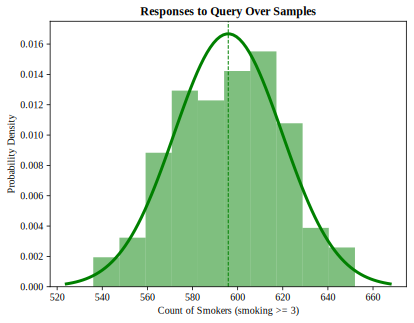

In [9]:
# Plot histogram of samples
plt.hist(samples, bins=10, density=True, alpha=0.5, color='g')

mu = np.mean(samples)
sigma = np.std(samples)

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='g', linewidth=3)
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)

plt.title('Responses to Query Over Samples')
plt.xlabel('Count of Smokers (smoking >= 3)')
plt.ylabel('Probability Density')
plt.savefig("figs/samples.png")

In [41]:
{'mean': mu, 'variance': sigma**2, 'covariance': np.cov(samples, samples)}

{'mean': 597.12,
 'variance': 616.2456,
 'covariance': array([[617.79007519, 617.79007519],
        [617.79007519, 617.79007519]])}

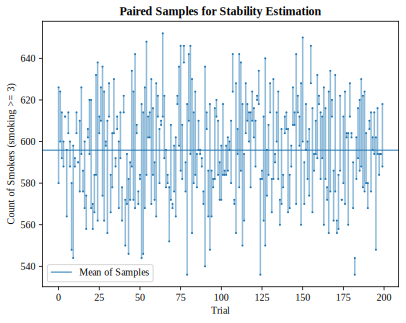

In [134]:
# plot sample points
plt.scatter(range(len(sample_pairs)), [sp[0] for sp in sample_pairs], alpha=1, color='tab:blue', s=1)
plt.scatter(range(len(sample_pairs)), [sp[1] for sp in sample_pairs], alpha=1, color='tab:blue', s=1)
for i, sp in enumerate(sample_pairs):
    plt.plot([i, i], [sp[0], sp[1]], color='tab:blue', alpha=0.5)

# depict mean as a line
plt.axhline(y=np.mean(samples), color='tab:blue', linestyle='-', lw=1, label='Mean of Samples')
plt.title('Paired Samples for Stability Estimation')
plt.xlabel('Trial')
plt.ylabel('Count of Smokers (smoking >= 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
plt.legend()
plt.savefig("figs/paired-samples.png")

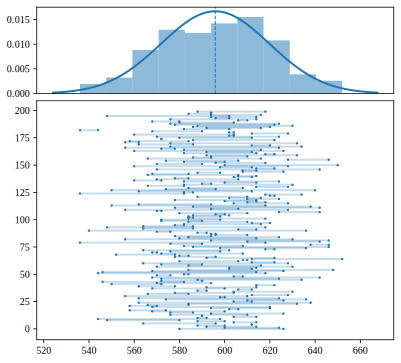

In [79]:
# plot both the histogram and the sample point intervals on the same plot, with the histogram on top and the intervals below as horizontal lines
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(6.4, 4.8*1.25))

# plot above main plot for histogram
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False, bottom=False)

# plot marginal histogram
ax_histx.hist(samples, bins=10, density=True, alpha=0.5, color='tab:blue', label='Samples')
ax_histx.plot(x, stats.norm.pdf(x, mu, sigma), color='tab:blue', linewidth=2, label='Sample Distribution')
ax_histx.axvline(mu, color='tab:blue', linestyle='dashed', linewidth=1)

# plot sample points horizontally
ax.scatter([sp[0] for sp in sample_pairs], range(len(sample_pairs)), alpha=1, color='tab:blue', s=2)
ax.scatter([sp[1] for sp in sample_pairs], range(len(sample_pairs)), alpha=1, color='tab:blue', s=2)
for i, sp in enumerate(sample_pairs):
    ax.plot([sp[0], sp[1]] ,[i, i], color='tab:blue', alpha=0.25, lw=2)


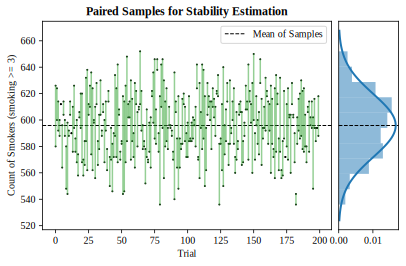

In [155]:
# plot both the histogram and the sample point intervals on the same plot, with the histogram on top and the intervals below as horizontal lines
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.set_aspect(1.)
# plot above main plot for histogram
divider = make_axes_locatable(ax)
ax_histy = divider.append_axes("right", 1/1.2, pad=0.1, sharey=ax)
ax_histy.yaxis.set_tick_params(labelleft=False, left=False)

# plot marginal histogram
ax_histy.hist(samples, bins=10, density=True, alpha=0.5, color='tab:blue', orientation='horizontal')
ax_histy.plot(stats.norm.pdf(x, mu, sigma), x, color='tab:blue', linewidth=2)
ax_histy.axhline(mu, color='black', linestyle='dashed', linewidth=1)

# plot sample points horizontally
ax.scatter(range(len(sample_pairs)), [sp[0] for sp in sample_pairs], alpha=1, color='black', s=1)
ax.scatter(range(len(sample_pairs)), [sp[1] for sp in sample_pairs], alpha=1, color='black', s=1)
ax.axhline(mu, color='black', linestyle='dashed', linewidth=1, label='Mean of Samples')

for i, sp in enumerate(sample_pairs):
    ax.plot([i, i], [sp[0], sp[1]], color='tab:green', alpha=0.5)

ax.set_title('Paired Samples for Stability Estimation')
ax.set_xlabel('Trial')
ax.set_ylabel('Count of Smokers (smoking >= 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
(ax.legend(
    [*ax.get_legend_handles_labels()[0], *ax_histy.get_legend_handles_labels()[0]],
    [*ax.get_legend_handles_labels()[1], *ax_histy.get_legend_handles_labels()[1]]
))
fig.savefig("figs/paired-with-histogram.png")

Text(0.5, 1.0, 'Sample Pair Distances')

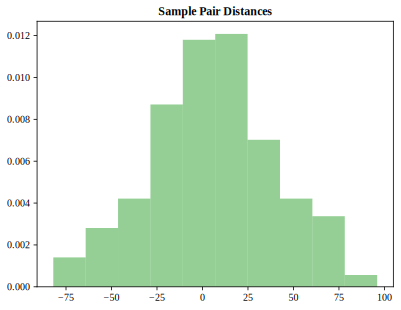

In [159]:
# plot distances of paired samples
plt.hist([sp[0]-sp[1] for sp in sample_pairs], bins=10, density=True, alpha=0.5, color='tab:green')
plt.title('Sample Pair Distances')

### Noise

Now we calculate the noise to add. I've attempted to construct what I need based on the PAC-ML code, but this probably has many errors.

Noise is estimated using Algorithm 2 from the PAC paper, with details taken from `rand_mechanism_noise` in the PAC-ML paper.

$\text{noise} = ((\psi + c) / (2*v))$ where $\psi$ is the average distance between paired samples and $v = \tt{max\_mi}/2$

In [160]:
import paclib

c = 0.001
max_mi = 1/32  # 2 * v

# find paired distances
dists = [np.abs(sp[0] - sp[1]) for sp in sample_pairs]
avg_dist = np.mean(dists)  # psi

# At different levels of MI, compute noise to add
noise_params = []
for max_mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {avg_dist}, c: {c}, max_mi: {max_mi:8} => {paclib.noise_to_add_parameters(avg_dist, c, max_mi)}")
    noise_params.append([max_mi, paclib.noise_to_add_parameters(avg_dist, c, max_mi).mean, paclib.noise_to_add_parameters(avg_dist, c, max_mi).variance])

avg_dist: 27.15, c: 0.001, max_mi: 0.015625 => GaussianDistribution(mean=0, variance=1737.664)
avg_dist: 27.15, c: 0.001, max_mi:  0.03125 => GaussianDistribution(mean=0, variance=868.832)
avg_dist: 27.15, c: 0.001, max_mi:   0.0625 => GaussianDistribution(mean=0, variance=434.416)
avg_dist: 27.15, c: 0.001, max_mi:    0.125 => GaussianDistribution(mean=0, variance=217.208)
avg_dist: 27.15, c: 0.001, max_mi:     0.25 => GaussianDistribution(mean=0, variance=108.604)
avg_dist: 27.15, c: 0.001, max_mi:      0.5 => GaussianDistribution(mean=0, variance=54.302)
avg_dist: 27.15, c: 0.001, max_mi:      1.0 => GaussianDistribution(mean=0, variance=27.151)
avg_dist: 27.15, c: 0.001, max_mi:      2.0 => GaussianDistribution(mean=0, variance=13.5755)
avg_dist: 27.15, c: 0.001, max_mi:      4.0 => GaussianDistribution(mean=0, variance=6.78775)


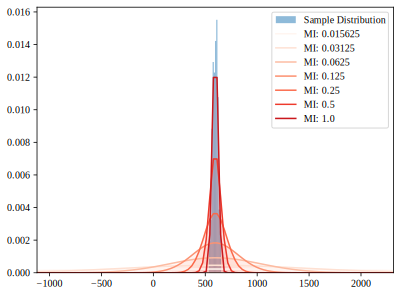

In [167]:
# plot original sample distribution
plt.hist(samples, bins=10, density=True, alpha=0.5, color='tab:blue', label="Sample Distribution")

sm = np.mean(samples)
sv = np.var(samples)

# colors = reds
colors = plt.cm.Reds(np.linspace(0, 1, len(noise_params)))
color_i = 0
def next_color():
    global color_i
    c = colors[color_i]
    color_i += 1
    return c

# for each mi, plot the normal distribution centered at mean with variance. have mis as legend
for max_mi, mean, variance in noise_params[:7]:
    c = next_color()
    mean = sm
    x = np.linspace(mean - 3*sv, mean + 3*sv, 100)
    plt.plot(x, stats.norm.pdf(x, mean, variance), label=f"MI: {max_mi}", color=c)
    plt.fill_between(x, stats.norm.pdf(x, mean, variance), alpha=0.1, color=c)

# set x axis to be the same as the original sample distribution
plt.xlim([sm - 3*sv, sm + 3*sv])

plt.legend()
plt.savefig("figs/noise.png")

In [39]:
# obtain one more sample to use for noised release
s = (pac_lung_df.sample()
     .filter(lung_df["Smoking"] >= 3)  # run query on sample
     .count())

mi = 1/32
noise_to_add = paclib.noise_to_add(avg_dist, c, mi)

noised_s = s + noise_to_add

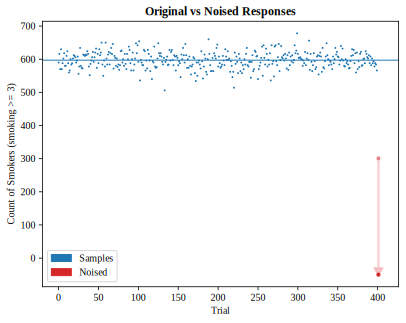

In [75]:
# plot samples
plt.scatter(range(len(samples)), samples, alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.mean(samples), color='tab:blue', linestyle='-', lw=1)

# plot noised response
plt.scatter([len(samples)+1], [s], alpha=0.4, color='tab:red', s=10)
plt.scatter([len(samples)+1], [noised_s], alpha=1, color='tab:red', s=10)
# plot arrow from sample to noised response
plt.arrow(len(samples)+1, s, 0, noised_s-s, color='tab:red', alpha=0.2, length_includes_head=True, head_width=10, head_length=20, lw=2.5)

plt.title('Original vs Noised Responses')
plt.xlabel('Trial')
plt.ylabel('Count of Smokers (smoking >= 3)')
plt.legend(handles=[mpatches.Patch(color='tab:blue', label='Samples'), mpatches.Patch(color='tab:red', label='Noised')])
#plt.ylim(bottom=0)
plt.savefig("figs/original-vs-noised.png")

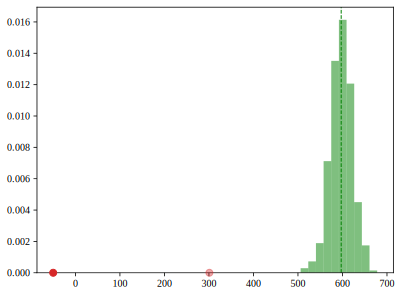

In [82]:
# plot noised response on original distribution
plt.hist(samples, bins=10, density=True, alpha=0.5, color='g')
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)

plt.scatter([s], [0], alpha=0.4, color='tab:red', s=50, zorder=10, clip_on=False)
plt.scatter([noised_s], [0], alpha=1, color='tab:red', s=50, zorder=10, clip_on=False)

### Multiple Tables

In [16]:
# Split the lung table into multiple tables over Patient Id
identity_df: DataFrame = lung_df.select("Name", "index", "Patient Id", "Age", "Gender")
identity_df.write.saveAsTable("identity", mode="overwrite")

symptoms_df: DataFrame = lung_df.select("Patient Id", "Chest Pain", "Coughing of Blood", "Fatigue", "Weight Loss", "Shortness of Breath", "Wheezing", "Swallowing Difficulty", "Clubbing of Finger Nails", "Frequent Cold", "Dry Cough", "Snoring")
symptoms_df.write.saveAsTable("symptoms", mode="overwrite")

risk_factors_df: DataFrame = lung_df.select("Patient Id", "Air Pollution", "Alcohol use", "Dust Allergy", "Occupational Hazards", "Genetic Risk", "Chronic Lung Disease", "Balanced Diet", "Obesity", "Smoking", "Passive Smoker")
risk_factors_df.write.saveAsTable("risk_factors", mode="overwrite")

In [17]:
# Count the number of patients in each age group with chest pain who are smokers
spark.sql("""
        SELECT FLOOR(identity.Age / 10) * 10 AS Age_Group, COUNT(*) AS Count
        FROM identity
        JOIN symptoms ON identity.`Patient Id` = symptoms.`Patient Id`
        JOIN risk_factors ON identity.`Patient Id` = risk_factors.`Patient Id`
        WHERE risk_factors.Smoking >= 3
          AND symptoms.`Chest Pain` > 1
        GROUP BY FLOOR(identity.Age / 10) * 10
        ORDER BY Age_Group
        """).toPandas()

,Age_Group,Count
0,10,28
1,20,106
2,30,222
3,40,120
4,50,30
5,60,31
6,70,10


In [18]:
spark_df: DataFrame = (identity_df.join(symptoms_df, "Patient Id") # First do all the joins
                 .join(risk_factors_df, "Patient Id"))
spark_df.count()

1000

In [25]:
(identity_df.join(symptoms_df, "Patient Id") # First do all the joins
        .join(risk_factors_df, "Patient Id")
        .df.filter(spark_df["Smoking"] >= 3)  # N
        .filter(spark_df["Chest Pain"] > 1)
        .withColumn("Age_Group", (spark_df["Age"] / 10).cast("int") * 10)
        .groupBy("Age_Group")
        .count()
        .orderBy("Age_Group")).show()

AttributeError: 'DataFrame' object has no attribute 'df'

In [19]:
# Subsample --> DBi

# Run M(DBi)
(spark_df.filter(spark_df["Smoking"] >= 3)  # N
         .filter(spark_df["Chest Pain"] > 1)
         .withColumn("Age_Group", (spark_df["Age"] / 10).cast("int") * 10)
         .groupBy("Age_Group")
         .count()
         .orderBy("Age_Group")).show()

# --> Covariance matrix
# interact with PAC library
# --> Noise
# PAC library

# Noised release of M(DBn+1) + noise

+---------+-----+
|Age_Group|count|
+---------+-----+
|       10|   28|
|       20|  106|
|       30|  222|
|       40|  120|
|       50|   30|
|       60|   31|
|       70|   10|
+---------+-----+



In [20]:
spark_df: DataFrame = (identity_df.join(symptoms_df, "Patient Id")
                 .join(risk_factors_df, "Patient Id"))

trials = 200
sampling_rate = 0.5

n = spark_df.count()

samples = []
for i in range(trials):
    s = (spark_df.sample(fraction=0.5, withReplacement=True)  # 50% sampling rate
         .filter(spark_df["Smoking"] >= 3)
         .filter(spark_df["Chest Pain"] > 1)
         .withColumn("Age_Group", (spark_df["Age"] / 10).cast("int") * 10)
         .groupBy("Age_Group")
         .count()
         .orderBy("Age_Group"))
    samples.append(s)  # store result of query

#samples = [s * (1/sampling_rate) for s in samples]  # so that counts are not halved

In [21]:
# samples is a list of DataFrames, convert to a Spark type
samples_rdd: RDD = spark.sparkContext.parallelize(samples)

Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/serializers.py", line 459, in dumps
    return cloudpickle.dumps(obj, pickle_protocol)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 73, in dumps
    cp.dump(obj)
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/cloudpickle/cloudpickle_fast.py", line 632, in dump
    return Pickler.dump(self, obj)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/pyspark/context.py", line 466, in __getnewargs__
    raise PySparkRuntimeError(
pyspark.errors.exceptions.base.PySparkRuntimeError: [CONTEXT_ONLY_VALID_ON_DRIVER] It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.


PicklingError: Could not serialize object: PySparkRuntimeError: [CONTEXT_ONLY_VALID_ON_DRIVER] It appears that you are attempting to reference SparkContext from a broadcast variable, action, or transformation. SparkContext can only be used on the driver, not in code that it run on workers. For more information, see SPARK-5063.